In [7]:
import os
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

In [8]:
# Îç∞Ïù¥ÌÑ∞ Í≤ΩÎ°ú
data_dir = "data"
valid_size = 0.2 # 20%Î•º ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Î°ú ÏÇ¨Ïö©

In [23]:
# Ïù¥ÎØ∏ÏßÄ Î≥ÄÌôò ÏÑ§Ï†ï (ResNet50Ïóê ÎßûÏ∂§)
transform = transforms.Compose([
    transforms.RandomResizedCrop(224), # 224x224Î°ú Î≥ÄÌôò
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.5), # Ï¢åÏö∞ Î∞òÏ†Ñ (Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï)
    transforms.RandomRotation(10), # ÌöåÏ†Ñ Ï∂îÍ∞Ä
    transforms.ToTensor(), # PyTorch ÌÖêÏÑú Î≥ÄÌôò
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ResNet50 Ï†ïÍ∑úÌôî : RGB Ï±ÑÎÑêÏùò ÌèâÍ∑†Í∞í
])

# Train/Test Split Ìï®Ïàò
def load_split_train_test(data_dir, valid_size=0.2, batch_size=16):
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    num_train = len(dataset)
    indices = list(range(num_train))
    np.random.shuffle(indices) # Îç∞Ïù¥ÌÑ∞ Î¨¥ÏûëÏúÑ

    split = int(np.floor(valid_size * num_train)) # 20%Î•º ÌÖåÏä§Ìä∏Î°ú ÏÇ¨Ïö©
    train_idx, test_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size)
    test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=batch_size)

    return train_loader, test_loader

# Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ïã§Ìñâ
train_loader, test_loader = load_split_train_test(data_dir, valid_size=0.2)

# Îç∞Ïù¥ÌÑ∞ Í∞úÏàò ÌôïÏù∏
print(f"Train Îç∞Ïù¥ÌÑ∞ Í∞úÏàò: {len(train_loader.dataset)}")
print(f"Test Îç∞Ïù¥ÌÑ∞ Í∞úÏàò: {len(test_loader.dataset)}")

Train Îç∞Ïù¥ÌÑ∞ Í∞úÏàò: 147
Test Îç∞Ïù¥ÌÑ∞ Í∞úÏàò: 147


ÏÇ¨Ï†Ñ ÌïôÏäµÎêú ResNet50ÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ Î∂ÑÎ•ò Î†àÏù¥Ïñ¥(Fully Connected Layer)Î•º ÏàòÏ†ï

In [49]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet50_Weights

# GPU ÏÇ¨Ïö© ÏÑ§Ï†ï
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet50 Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞ (ÏÇ¨Ï†Ñ ÌïôÏäµÎêú Í∞ÄÏ§ëÏπò ÏÇ¨Ïö©)
model = models.resnet50(pretrained=True) 

# torchvision 0.13 Ïù¥ÌõÑ Î≥ÄÍ≤Ω Î∞©Î≤ïÎ≤ï

# ÎßàÏßÄÎßâ Fully Connected Layer ÏàòÏ†ï
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) # 2Í∞ú ÌÅ¥ÎûòÏä§ (ÏïûÎ™®Ïäµ/Îí∑Î™®Ïäµ)

# Î™®Îç∏ÏùÑ GPUÎ°ú Ïù¥Îèô
model = model.to(device)
print(device)


cpu


C:\Users\user\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
# ÏÜêÏã§ Ìï®Ïàò Î∞è ÏòµÌã∞ÎßàÏù¥Ï†Ä Ï†ïÏùò
criterion = nn.CrossEntropyLoss() # Îã§Ï§ë ÌÅ¥ÎûòÏä§ Î∂ÑÎ•òÏö© ÏÜêÏã§ Ìï®Ïàò
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

epochs = 10
print_every = 5 # 5Ìöå Î∞∞ÏπòÎßàÎã§ Í≤∞Í≥º Ï∂úÎ†•
running_loss = 0
steps = 0 # ÌïôÏäµ Îã®Í≥Ñ Ïπ¥Ïö¥Ìä∏
train_losses, test_losses = [], [] # ÏÜêÏã§Í∞í Ï†ÄÏû• Î¶¨Ïä§Ìä∏

# ÌïôÏäµ Î£®ÌîÑ
for epoch in range(epochs):
    model.train() # ÌïôÏäµÎ™®ÎìúÎ°ú ÏÑ§Ï†ï
    running_loss = 0.0 # ÏÜêÏã§Í∞í Ï¥àÍ∏∞Ìôî

    for images, labels in train_loader:
        steps += 1 # ÌïôÏäµ Îã®Í≥Ñ Ïπ¥Ïö¥Ìä∏
        images, labels = images.to(device), labels.to(device) # Îç∞Ïù¥ÌÑ∞ gpu/cpuÎ°ú Ïù¥Îèô
        optimizer.zero_grad() # ÏòµÌã∞ÎßàÏù¥Ï†Ä Ï¥àÍ∏∞Ìôî

        # forward Î∞è ÏÜêÏã§
        outputs = model(images) 
        loss = criterion(outputs, labels) 

        # backward Î∞è ÏµúÏ†ÅÌôî
        loss.backward()
        optimizer.step()

        # ÏÜêÏã§Í∞í ÎàÑÏ†Å
        running_loss += loss.item()

        # ÏùºÏ†ï Î∞∞ÏπòÎßàÎã§ Î™®Îç∏ ÌèâÍ∞Ä
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval() # ÌèâÍ∞Ä Î™®Îìú Ï†ÑÌôò

            # Î™®Îç∏ ÌèâÍ∞Ä
            with torch.no_grad(): # gradient Í≥ÑÏÇ∞ X
                correct_test, total_test = 0, 0
                for test_images, test_labels in test_loader:
                    test_images, test_labels = test_images.to(device), test_labels.to(device)

                    # forward Î∞è loss Í≥ÑÏÇ∞
                    test_outputs = model(test_images)
                    batch_loss = criterion(test_outputs, test_labels)
                    test_loss += batch_loss.item()

                    # ÏòàÏ∏°Í∞í Í≥ÑÏÇ∞
                    _, predicted = torch.max(test_outputs, 1) # Í∞ÄÏû• ÎÜíÏùÄ ÌôïÎ•† ÌÅ¥ÎûòÏä§ ÏÑ†ÌÉù
                    total_test += test_labels.size(0)
                    correct_test += (predicted == test_labels).sum().item()

            test_accuracy = 100 * correct_test /total_test

            # ÏÜêÏã§Í∞í Ï†ÄÏû•
            train_losses.append(running_loss / print_every)
            test_losses.append(test_loss / len(test_loader))

            # Í≤∞Í≥º Î°úÍ∑∏ Ï∂úÎ†•
            print(f"Epoch [{epoch+1}/{epochs}] | "
                f"Train Loss: {running_loss / print_every:.3f} | "
                f"Test Loss: {test_loss/len(test_loader):.3f} | "
                f"Test Accuracy: {test_accuracy:.2f}" )

            # loss Ï¥àÍ∏∞Ìôî
            running_loss = 0
            model.train() # Îã§Ïãú ÌïôÏäµ Î™®ÎìúÎ°ú Ï†ÑÌôòÌôò

Epoch [1/10] | Train Loss: 0.394 | Test Loss: 0.480 | Test Accuracy: 72.41
Epoch [2/10] | Train Loss: 0.153 | Test Loss: 0.548 | Test Accuracy: 75.86
Epoch [2/10] | Train Loss: 0.307 | Test Loss: 0.341 | Test Accuracy: 86.21
Epoch [3/10] | Train Loss: 0.134 | Test Loss: 0.250 | Test Accuracy: 89.66
Epoch [4/10] | Train Loss: 0.068 | Test Loss: 0.173 | Test Accuracy: 96.55
Epoch [4/10] | Train Loss: 0.164 | Test Loss: 0.237 | Test Accuracy: 89.66
Epoch [5/10] | Train Loss: 0.079 | Test Loss: 0.528 | Test Accuracy: 79.31
Epoch [5/10] | Train Loss: 0.071 | Test Loss: 0.426 | Test Accuracy: 89.66
Epoch [6/10] | Train Loss: 0.107 | Test Loss: 0.296 | Test Accuracy: 93.10
Epoch [7/10] | Train Loss: 0.037 | Test Loss: 0.398 | Test Accuracy: 82.76
Epoch [7/10] | Train Loss: 0.097 | Test Loss: 0.079 | Test Accuracy: 96.55
Epoch [8/10] | Train Loss: 0.062 | Test Loss: 0.236 | Test Accuracy: 89.66
Epoch [9/10] | Train Loss: 0.007 | Test Loss: 0.308 | Test Accuracy: 86.21
Epoch [9/10] | Train Loss

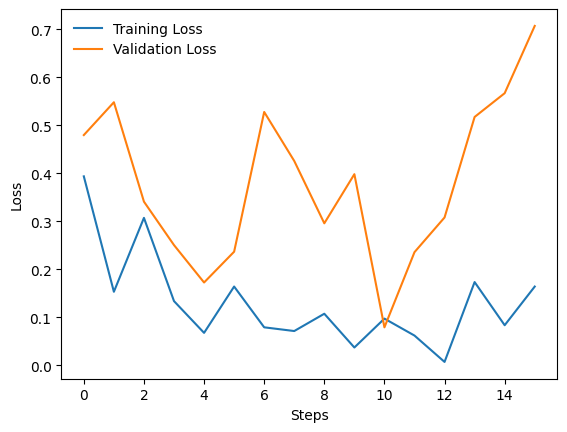

In [29]:
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

lossÍ∞Ä Ï†ÑÎ∞òÏ†ÅÏúºÎ°ú Ï§ÑÍ∏∞Îäî ÌïòÎÇò ÏÑ±Îä• Î≥ÄÌôî ÏùºÍ¥ÄÏÑ±Ïù¥ ÏóÜÏùå (Îì§Ïë•ÎÇ†Ïë•) - 
Í≥ºÏ†ÅÌï© Ï∂îÏ†ï


Í≥ºÏ†ÅÌï© ÏôÑÌôî Î∞©Î≤ï
- Dropout Î†àÏù¥Ïñ¥ Ï∂îÍ∞Ä
- L2 Ï†ïÍ∑úÌôî (weight_decay) Ï†ÅÏö©


Î™®Îç∏ ÌèâÍ∞Ä Î∞©Î≤ï
- Î™®Îç∏Ïù¥ ÏòàÏ∏°Ìïú Í∞íÍ≥º Ïã§Ï†ú ÎùºÎ≤®ÏùÑ ÎπÑÍµêÌïòÏó¨ Ï†ïÌôïÎèÑ Ï∏°Ï†ï
- torch.max(outputs, 1)Î•º ÏÇ¨Ïö©ÌïòÏó¨ Í∞ÄÏû• ÎÜíÏùÄ ÌôïÎ•†ÏùÑ Í∞ÄÏßÑ ÌÅ¥ÎûòÏä§Î•º ÏòàÏ∏°

In [30]:
model.eval() # ÌèâÍ∞Ä Î™®ÎìúÎ°ú Ï†ÑÌôò

correct = 0
total = 0

with torch.no_grad(): # ÌèâÍ∞Ä Ïãú Gradient Í≥ÑÏÇ∞ X
    for images, labels in test_loader: # Î∞∞Ïπò Îã®ÏúÑÎ°ú ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Í∞ÄÏ†∏Ïò§Í∏∞
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1) # Í∞ÄÏû• ÎÜíÏùÄ ÌôïÎ•†Ïùò ÌÅ¥ÎûòÏä§ ÏÑ†ÌÉù
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"accuracy: {accuracy:.2f}%")

accuracy: 86.21%


Î™®Îç∏ Ï†ÄÏû•

In [31]:
# state_dict()Î°ú Í∞ÄÏ§ëÏπòÏôÄ Ìé∏Ìñ•ÏùÑ Ï†ÄÏû•
# torch.save(model, "best_model.pth") Î°ú Ï†ÄÏû• Ïãú Î™®Îç∏ Íµ¨Ï°∞ÍπåÏßÄ Ï†ÄÏû• Îê® -> Íµ¨Ï°∞Í∞Ä Îã§Î•¥Î©¥ Ïò§Î•ò Î∞úÏÉù Í∞ÄÎä•
torch.save(model.state_dict(), "best_model.pth")
print("Ï†ÄÏû• ÏôÑÎ£å")

Ï†ÄÏû• ÏôÑÎ£å


In [32]:
# Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞
# ÌòÑÏû¨ ÏÑ†Ïñ∏Îêú Î™®Îç∏Ïóê Í∞ÄÏ§ëÏπò Ï†ÅÏö©
# gpuÏóêÏÑú Ï†ÄÏû•Îêú Î™®Îç∏Ïù¥Ïñ¥ÎèÑ cpuÏóêÏÑú Î∂àÎü¨Ïò¨ Ïàò ÏûàÎèÑÎ°ù ÏÑ§Ï†ï
model.load_state_dict(torch.load("best_model.pth", map_location=torch.device("cpu")))

<All keys matched successfully>

# ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄ ÏòàÏ∏° ÌÖåÏä§Ìä∏

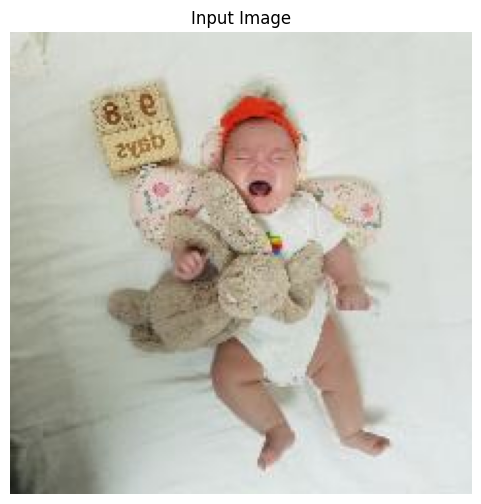

Î™®Îç∏ ÏòàÏ∏° Í≤∞Í≥º: Back (61.56%)


In [42]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models
from torchvision.models import ResNet50_Weights
import torch.nn.functional as F  # üîπ SoftmaxÎ•º ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌï¥ Ï∂îÍ∞Ä

# Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞ (ÏµúÏã† Î∞©Ïãù Ï†ÅÏö©)
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Fully Connected Layer ÏàòÏ†ï (ÏïûÎ™®Ïäµ: 1, Îí∑Î™®Ïäµ: 0)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)  # 2Í∞ú ÌÅ¥ÎûòÏä§
model.load_state_dict(torch.load("best_model.pth", map_location=torch.device("cpu")))  # ÌïôÏäµÎêú Î™®Îç∏ Î°úÎìú
model.eval()  # ÌèâÍ∞Ä Î™®Îìú Ï†ÑÌôò

# Ïù¥ÎØ∏ÏßÄ Î≥ÄÌôò ÏÑ§Ï†ï (Î™®Îç∏Í≥º ÎèôÏùºÌïòÍ≤å Ï†ÅÏö©)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_image(image_path):
    # Ïù¥ÎØ∏ÏßÄ Î°úÎìú Î∞è RGB ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
    image = Image.open(image_path).convert("RGB")

    # Ïù¥ÎØ∏ÏßÄ Ï∂úÎ†•
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off") 
    plt.title("Input Image")
    plt.show()

    # Î™®Îç∏ ÏûÖÎ†•ÏùÑ ÏúÑÌïú Î≥ÄÌôò Ï†ÅÏö©
    image_tensor = transform(image).unsqueeze(0)  # Î≥ÄÌôò ÌõÑ Î∞∞Ïπò Ï∞®Ïõê Ï∂îÍ∞Ä

    # Î™®Îç∏ ÏòàÏ∏°
    with torch.no_grad():
        output = model(image_tensor)  # Î™®Îç∏Ïùò ÏõêÎ≥∏ Ï∂úÎ†• (Logits)
        probabilities = F.softmax(output, dim=1)  # üîπ Softmax Ï†ÅÏö© (ÌôïÎ•† Î≥ÄÌôò)
        confidence, predicted = torch.max(probabilities, 1)  # üîπ ÌôïÎ•†Ïù¥ Í∞ÄÏû• ÎÜíÏùÄ ÌÅ¥ÎûòÏä§ ÏÑ†ÌÉù

    # ÏòàÏ∏° Í≤∞Í≥º Ï∂úÎ†•
    class_names = ["Back", "Front"]  # 0: Back, 1: Front
    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item() * 100  # üîπ Î∞±Î∂ÑÏú® Î≥ÄÌôò

    print(f"Î™®Îç∏ ÏòàÏ∏° Í≤∞Í≥º: {predicted_class} ({confidence_score:.2f}%)")  # üîπ ÌôïÎ•† Ï∂îÍ∞Ä

# ÏòàÏ∏°Ìï† Ïù¥ÎØ∏ÏßÄ
predict_image(r"data\front\front_0004.jpeg")



Î™®Îç∏ ÌèâÍ∞Ä

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import numpy as np

def evaluate_model(model, test_loader):
    model.eval() # ÌèâÍ∞Ä Î™®Îìú
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cpu"), labels.to("cpu")
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    # ÌèâÍ∞Ä
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="binary")
    recall = recall_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")
    cm = confusion_matrix(y_true, y_pred)

    # ÌèâÍ∞Ä Í≤∞Í≥º
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # confusion matrix ÏãúÍ∞ÅÌôî
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Back", "Front"], yticklabels=["Back", "Front"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

Accuracy : 0.8621
Precision: 0.800000
Recall: 0.9231
F1-Score: 0.8571


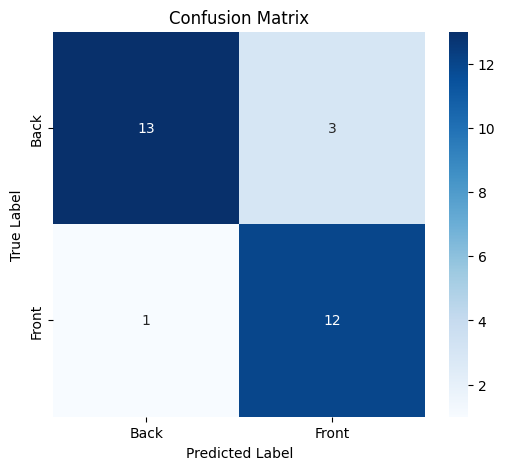

In [44]:
evaluate_model(model, test_loader)